In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import time
import matplotlib.pyplot as plt

In [ ]:
aqi_df = pd.read_csv('datasets/aqi_augmented.csv', index_col = 0)
aqi_df.head()

In [90]:
# first see how many nulls are in each column
print(aqi_df.shape)
pd.isnull(aqi_df).sum()/aqi_df.shape[0]

(7243237, 33)


STATE_NAME                         0.000000
COUNTY_CODE                        0.000000
DATE                               0.000000
AQI                                0.000000
FIRES_COUNT_COUNTY_0_WEEK_PRIOR    0.000000
FIRES_SIZE_COUNTY_0_WEEK_PRIOR     0.000000
FIRES_COUNT_STATE_0_WEEK_PRIOR     0.000000
FIRES_SIZE_STATE_0_WEEK_PRIOR      0.000000
FIRES_COUNT_COUNTY_1_WEEK_PRIOR    0.000000
FIRES_SIZE_COUNTY_1_WEEK_PRIOR     0.000000
FIRES_COUNT_STATE_1_WEEK_PRIOR     0.000000
FIRES_SIZE_STATE_1_WEEK_PRIOR      0.000000
FIRES_COUNT_COUNTY_2_WEEK_PRIOR    0.000000
FIRES_SIZE_COUNTY_2_WEEK_PRIOR     0.000000
FIRES_COUNT_STATE_2_WEEK_PRIOR     0.000000
FIRES_SIZE_STATE_2_WEEK_PRIOR      0.000000
AQI_1_PRIOR                        0.000000
AQI_2_PRIOR                        0.000000
AQI_3_PRIOR                        0.000000
AQI_1_DAY_OFFSET                   0.071659
AQI_2_DAY_OFFSET                   0.071612
AQI_3_DAY_OFFSET                   0.035406
AQI_4_DAY_OFFSET                

In [91]:
# all see how many zeros show up in each column
print(aqi_df.shape)
(aqi_df == 0).sum()/aqi_df.shape[0]

(7243237, 33)


STATE_NAME                         0.000000
COUNTY_CODE                        0.000000
DATE                               0.000000
AQI                                0.003814
FIRES_COUNT_COUNTY_0_WEEK_PRIOR    0.940195
FIRES_SIZE_COUNTY_0_WEEK_PRIOR     0.940195
FIRES_COUNT_STATE_0_WEEK_PRIOR     0.516777
FIRES_SIZE_STATE_0_WEEK_PRIOR      0.516777
FIRES_COUNT_COUNTY_1_WEEK_PRIOR    0.940163
FIRES_SIZE_COUNTY_1_WEEK_PRIOR     0.940163
FIRES_COUNT_STATE_1_WEEK_PRIOR     0.516736
FIRES_SIZE_STATE_1_WEEK_PRIOR      0.516736
FIRES_COUNT_COUNTY_2_WEEK_PRIOR    0.940186
FIRES_SIZE_COUNTY_2_WEEK_PRIOR     0.940186
FIRES_COUNT_STATE_2_WEEK_PRIOR     0.516818
FIRES_SIZE_STATE_2_WEEK_PRIOR      0.516818
AQI_1_PRIOR                        0.003813
AQI_2_PRIOR                        0.003813
AQI_3_PRIOR                        0.003811
AQI_1_DAY_OFFSET                   0.003666
AQI_2_DAY_OFFSET                   0.003641
AQI_3_DAY_OFFSET                   0.003696
AQI_4_DAY_OFFSET                

In [4]:
# fill in previous days with a back-fill (can't have blank features)
last = -7
for d in range(-1, last -1, -1):
    col_name = f'AQI_{d}_DAY_OFFSET'
    prev_name = f'AQI_{d+1}_DAY_OFFSET' if d != -1 else 'AQI'
    aqi_df[col_name][pd.isnull(aqi_df[col_name])] = aqi_df[prev_name][pd.isnull(aqi_df[col_name])]

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
# ensure the backfill made no nulls for negative offsets
print(aqi_df.shape)
pd.isnull(aqi_df).sum()

(7243237, 33)


STATE_NAME                              0
COUNTY_CODE                             0
DATE                                    0
AQI                                     0
FIRES_COUNT_COUNTY_0_WEEK_PRIOR         0
FIRES_SIZE_COUNTY_0_WEEK_PRIOR          0
FIRES_COUNT_STATE_0_WEEK_PRIOR          0
FIRES_SIZE_STATE_0_WEEK_PRIOR           0
FIRES_COUNT_COUNTY_1_WEEK_PRIOR         0
FIRES_SIZE_COUNTY_1_WEEK_PRIOR          0
FIRES_COUNT_STATE_1_WEEK_PRIOR          0
FIRES_SIZE_STATE_1_WEEK_PRIOR           0
FIRES_COUNT_COUNTY_2_WEEK_PRIOR         0
FIRES_SIZE_COUNTY_2_WEEK_PRIOR          0
FIRES_COUNT_STATE_2_WEEK_PRIOR          0
FIRES_SIZE_STATE_2_WEEK_PRIOR           0
AQI_1_PRIOR                             0
AQI_2_PRIOR                             0
AQI_3_PRIOR                             0
AQI_1_DAY_OFFSET                   519043
AQI_2_DAY_OFFSET                   518703
AQI_3_DAY_OFFSET                   256453
AQI_4_DAY_OFFSET                   533355
AQI_5_DAY_OFFSET                  

In [128]:
# random forest way too slow... RandomForestRegressor(n_estimators=1, max_depth=20, random_state=42, verbose=True)
# lasso faster linear_model.Lasso(alpha=0.1)
# linear regression fast linear_model.LinearRegression()
def build_k_day_classifier(aqi_df, clf = linear_model.Lasso(alpha=0.3), k=1):
    # find feature columns and label column
    cols = set(aqi_df.columns)
    features = list(cols - ({'STATE_NAME', 'COUNTY_CODE', 'DATE'} | {f'AQI_{i}_DAY_OFFSET' for i in range(1,8)}))
    label = f'AQI_{k}_DAY_OFFSET'
    
    # remove all rows w/out label
    mask = ~pd.isnull(aqi_df[label])
    X = aqi_df.loc[mask, features].to_numpy()
    y = aqi_df[label][mask].to_numpy()
    
    # do a split of data
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split = int(indices.shape[0]*.8)
    
    # do a scaling to improve speed convergence
    sc = StandardScaler()
    sc.fit(X[indices[:split]])
    
    # train
    s = time.time()
    clf.fit(sc.transform(X[indices[:split]]),\
            y[indices[:split]])
    print(f'Training took {time.time()-s:.2f} sec')
    
    # evaluate
    s = time.time()
    y_test_pred = clf.predict(sc.transform(X[indices[split:]]))
    y_train_pred = clf.predict(sc.transform(X[indices[:split]]))
    print(f'Evaluation took {time.time()-s:.2f} sec')
    
    return clf,  y[indices[:split]], y_train_pred, y[indices[split:]], y_test_pred, features
model_name = 'lasso'
clf, y_train, y_train_pred, y_test, y_test_pred, features = build_k_day_classifier(aqi_df)

Training took 22.66 sec
Evaluation took 20.89 sec


In [129]:
# now see how good it was
def summary_results(y_test, y_pred):
    result = {
        'mean absolute error': metrics.mean_absolute_error(y_test, y_pred),
        'mean squared error': metrics.mean_squared_error(y_test, y_pred),
        'explained variance': metrics.explained_variance_score(y_test, y_pred)
    }
    metric_dict = {
        'mean test': np.mean(y_test),
        'std test': np.std(y_test),
        'mean pred': np.mean(y_pred),
        'std pred': np.std(y_pred)
    }
    return result, metric_dict
results, metric_dict = summary_results(y_train, y_train_pred)
print('Results Train')
print(results)
print(metric_dict)
results, metric_dict = summary_results(y_test, y_test_pred)
print('Results Test')
print(results)
print(metric_dict)

Results Train
{'mean absolute error': 16.17606326858309, 'mean squared error': 1083.5303353569443, 'explained variance': 0.19966919524432558}
{'mean test': 45.67439851060211, 'std test': 36.79474273444731, 'mean pred': 45.67439851060217, 'std pred': 16.01229280246581}
Results Test
{'mean absolute error': 16.171087489283135, 'mean squared error': 803.0279783731768, 'explained variance': 0.2486708404174922}
{'mean test': 45.621284778326626, 'std test': 32.6926207829735, 'mean pred': 45.66338536984892, 'std pred': 16.467255351604283}


In [130]:
#benchmark this with using mean of train set
mean_pred = np.mean(y_train) * np.ones(shape=y_test.shape)
results, metric_dict = summary_results(y_test, mean_pred)
results, metric_dict 

({'mean absolute error': 20.340504102614194,
  'mean squared error': 1068.8102747278672,
  'explained variance': 0.0},
 {'mean test': 45.621284778326626,
  'std test': 32.6926207829735,
  'mean pred': 45.67439851060221,
  'std pred': 9.947598300641403e-14})

In [131]:
# see which coefficients mattered
coefs, features = zip(*sorted(zip(np.abs(clf.coef_), features), reverse=True))
for f,c in zip(features, coefs):
    print(f,c)

AQI_-1_DAY_OFFSET 6.4360995996892285
AQI_-7_DAY_OFFSET 3.2956472692226595
AQI_-5_DAY_OFFSET 3.170959766904481
AQI_-2_DAY_OFFSET 3.1103199697619734
AQI_-3_DAY_OFFSET 2.808456311992578
AQI_-6_DAY_OFFSET 2.5551916306805036
AQI_-4_DAY_OFFSET 1.8284571621197607
FIRES_SIZE_STATE_2_WEEK_PRIOR 0.0
FIRES_SIZE_STATE_1_WEEK_PRIOR 0.0
FIRES_SIZE_STATE_0_WEEK_PRIOR 0.0
FIRES_SIZE_COUNTY_2_WEEK_PRIOR 0.0
FIRES_SIZE_COUNTY_1_WEEK_PRIOR 0.0
FIRES_SIZE_COUNTY_0_WEEK_PRIOR 0.0
FIRES_COUNT_STATE_2_WEEK_PRIOR 0.0
FIRES_COUNT_STATE_1_WEEK_PRIOR 0.0
FIRES_COUNT_STATE_0_WEEK_PRIOR 0.0
FIRES_COUNT_COUNTY_2_WEEK_PRIOR 0.0
FIRES_COUNT_COUNTY_1_WEEK_PRIOR 0.0
FIRES_COUNT_COUNTY_0_WEEK_PRIOR 0.0
AQI_3_PRIOR 0.0
AQI_2_PRIOR 0.0
AQI_1_PRIOR 0.0
AQI 0.0


(1344712, 3)


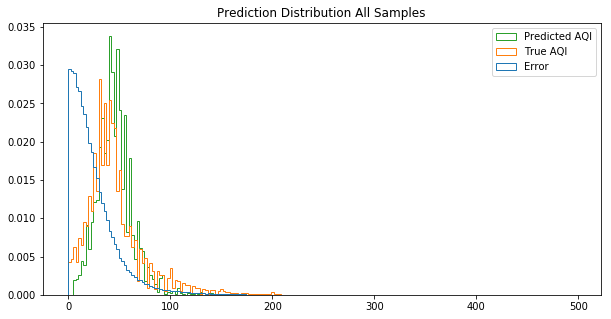

In [132]:
# see the error distribution
error = np.abs(y_test - y_pred)
mask = (y_test<500) & (error < 500)
hist = np.stack([error[mask], y_test[mask], y_pred[mask]]).T
print(hist.shape)
plt.figure(figsize=(10,5))
plt.hist(hist, bins = 200, density=True, histtype='step', label=['Error', 'True AQI', 'Predicted AQI'])
plt.legend()
plt.title('Prediction Distribution All Samples')
plt.savefig(f'analysis_plots/histogram_all_{model_name}.png')
plt.show()

(75249, 3)


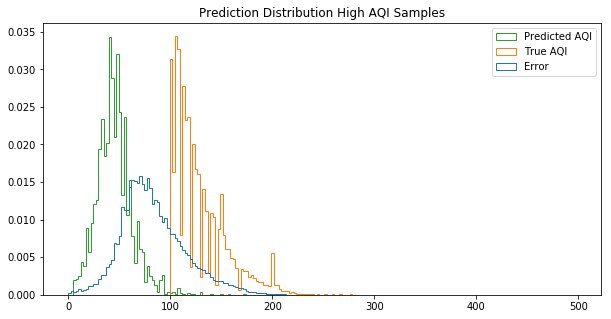

In [134]:
# see the error distribution for high aqi values
error = np.abs(y_test - y_pred)
mask = (100<y_test) & (y_test<500)
hist = np.stack([error[mask], y_test[mask], y_pred[mask]]).T
print(hist.shape)
plt.figure(figsize=(10,5))
plt.hist(hist, bins = 200, density=True, histtype='step', label=['Error', 'True AQI', 'Predicted AQI'])
plt.legend()
plt.title('Prediction Distribution High AQI Samples')
plt.savefig(f'analysis_plots/histogram_high_aqi_{model_name}.png')
plt.show()